# Applied Machine Learning Systems (MLS-1) - ELEC0134

# Final Assignment - Classification of Brain Tumours

## Task A - Binary Classification using Support Vector Machines (SVM)

## Completed by Student Number - 18014580

The cell below is only used when running the code on Google Colaboratory, and is always commented out otherwise.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


This is a Jupyter Notebook submitted as part of the final assignment for the Applied Machine Learning Systems (MLS-1) coursework which involves tumor classification and identification.

This particular notebook tests the SVM method using the SVC model from the `sklearn` library on Task A to find the accuracy of using support vector machines classification for this particular task of binary classification of tumours.

### Importing different packages

Initially, we must import the different packages needed for this task. The packages required to implement suport vector machines for this binary task can be found in `pandas`, `numpy`, `sklearn` (scikit-learn), `skimage` (scikit-image). 

`seaborn` and `matplotlib` are also required for graphs and confusion matrix visualisations.

Please ensure these are installed in your virtualenv before running the cell below as this will extract the packages required from these libraries. `os` and `datetime` are also required but these are found under Python's standard utility modules.

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from skimage import io
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.feature import hog

import matplotlib.pyplot as plt

import os
from os import listdir

import seaborn as sns

from datetime import datetime

print("All imports carried out successfully")

All imports carried out successfully


In [3]:
taskA_start = datetime.now()

### Loading the data from the data sets

In this cell we are using read_csv to load the labels for each image into a dataframe. We then display the dataframe to ensure the data from the .csv file was loaded correctly.

Comment out the Google Drive path and uncomment the Jupyter path when running on Notebook (not Colab) as the dataset and test files will be in the same directory as the .ipynb files when downloaded from the GitHub repository `AMLS_21-22_SN18014580`. Always use the Jupyter path if not using Google Colaboratory.

Ensure the folders "test" and "dataset" are in the same folder as the Notebook before running it.


In [4]:
#Loading the CSV file 'label' containing the different labels for each MRI Scan

#Used this path while running on Google Colab for accelerated GPU
label_path_GDrive = '/content/drive/MyDrive/Colab Notebooks/dataset/label.csv'

#Used this path when running regularly on Jupyter Notebook from repository
label_path_Jupyter = '.dataset/label.csv'

#tumour_labels = pd.read_csv(label_path_GDrive)
tumour_labels = pd.read_csv(label_path_Jupyter)

print(tumour_labels.shape) #Outputs array with the shape of the dataframe to ensure all images, filenames and labels loaded

(3000, 2)


In [5]:
tumour_labels #Displaying data frame to visually ensure data loaded correctly

,file_name,label
0,IMAGE_0000.jpg,meningioma_tumor
1,IMAGE_0001.jpg,no_tumor
2,IMAGE_0002.jpg,meningioma_tumor
3,IMAGE_0003.jpg,glioma_tumor
4,IMAGE_0004.jpg,meningioma_tumor
...,...,...
2995,IMAGE_2995.jpg,no_tumor
2996,IMAGE_2996.jpg,meningioma_tumor
2997,IMAGE_2997.jpg,glioma_tumor
2998,IMAGE_2998.jpg,glioma_tumor


### Printing out dataset to ensure labels changed accordingly

This is a binary classification task, so in the cells below, we modify the data frame by locating all the images whose label is not "no_tumor" and setting them to tumor rather than having them as the types of tumor.

In [6]:
#change anything in the label column that is not equal to "no_tumor" to "tumor" rather than the type of tumor
tumour_labels.loc[tumour_labels['label']!= 'no_tumor', 'label'] = 'tumor' 

In [7]:
tumour_labels #Displaying data frame to visually ensure labels changed as specified in cell above

,file_name,label
0,IMAGE_0000.jpg,tumor
1,IMAGE_0001.jpg,no_tumor
2,IMAGE_0002.jpg,tumor
3,IMAGE_0003.jpg,tumor
4,IMAGE_0004.jpg,tumor
...,...,...
2995,IMAGE_2995.jpg,no_tumor
2996,IMAGE_2996.jpg,tumor
2997,IMAGE_2997.jpg,tumor
2998,IMAGE_2998.jpg,tumor


### Adding numeric representation to the data frame¶

In the cells below, we add another column to the data frame and assign a numeric value label to each label. Since our problem is binary, the numeric label can only be 1 or 0.

If the label indicates "tumor" it is assigned a numeric label 1, and if the label does not indicate a tumour "no_tumor" it is assigned the numeric label 0. It also increases adaptability or convenience of the code if deep-learning models were to be used to have numeric label rather than a text label.

In [8]:
classes = ['no_tumor', 'tumor']
for CLASS in classes:
    tumour_labels.loc[tumour_labels['label'] == CLASS, 'numeric label'] = classes.index(CLASS)

In [9]:
tumour_labels #Displaying dataframe to ensure new column created and values are being assigned properly

,file_name,label,numeric label
0,IMAGE_0000.jpg,tumor,1.0
1,IMAGE_0001.jpg,no_tumor,0.0
2,IMAGE_0002.jpg,tumor,1.0
3,IMAGE_0003.jpg,tumor,1.0
4,IMAGE_0004.jpg,tumor,1.0
...,...,...,...
2995,IMAGE_2995.jpg,no_tumor,0.0
2996,IMAGE_2996.jpg,tumor,1.0
2997,IMAGE_2997.jpg,tumor,1.0
2998,IMAGE_2998.jpg,tumor,1.0


### Data Preparation: Loading the images

In the cell below, we load the image files using the `imread` functions from the scikit-image package. We convert the images to grayscale as a form of preprocessing. 

The images (whether grayscale or not) are converted to numpy arrays before appending them to a list. This list of arrays is then converted to a numpy array of arrays to allow us to print the shape to verify all the images have been loaded.

This cell also uses `datetime.now()` to output the time elapsed to load the image set. This was used to compare efficiency of different `imread` functions from different packages including `skimage`, `cv2` etc. In the end, `skimage` was chosen as it produced slightly favourable results.

The time elapsed to load the images was:  0:01:07.572150
(3000, 512, 512)


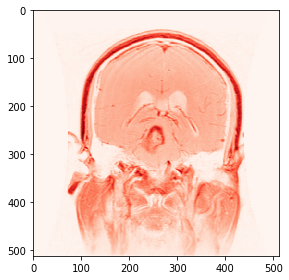

In [10]:
#Uncomment to verify contents of the directory loaded

""" directory contains the path of the image folder on the computer for running on Jupyter notebook when all files are in the same directory  
    drive_directory contains the path of the image folder on Google Drive for when Colab was being used for higher computational power.

    NOTE: As the order of the images was reshuffled when being uploaded to Google Drive due to internet speeds, we must use sorted() at the
    beginning of the for-loop when using dirpath otherwise the images will not be loaded in the order matching their corresponding labels. 
    Explicity this means when using Colab the for loop should read "for file in sorted(listdir(drive_directory))" instead of
    "for file in listdir(directory)".
    
    Change the name of the path in the for loop accordingly."""

directory = './dataset/image'
drive_directory = '/content/drive/MyDrive/Colab Notebooks/dataset/image'
#print(listdir(directory))
#print(listdir(drive_directory))

#Code used to test timing

start = datetime.now() #Stores the time at which loading starts

images = [] #An empty list is created

"""The for loop below uses listdir to iterate through names of all the files in the directory and uses to
populate the list images. The image is converted into grayscale using rgb2gray as this grayscale images only
have one channel which will increase efficiency of the code as we and decrease complexity whilst still yielding 
similar results. Testing carried out by me showed that we should stick to grayscale.

The user can optionally comment out lines 34 - 36 and uncomment lines 38 and 39 to leave the image in RGB rather
than convert it to grayscale"""

for file in sorted(listdir(directory)):
    img = io.imread(directory + '/' + file)
    gray_img = rgb2gray(img)
    gray_img = np.array(gray_img)
    images.append(gray_img)
    
    #img = np.array(img)
    #images.append(img) 
        
#Marking the end of the code loading the images 
end = datetime.now()
elapsed = end - start #Calculating time elapsed while comparing different packages used to load images
print('The time elapsed to load the images was: ', + elapsed) 

"""Below we chose a random image from the dataset (image[45]) to show below so the user can visually verify
the type of image. We apply a red colormap in the imshow function so that if the image is shown with red tones
the user knows it was converted to grayscale and if it shows as a regular black and white MRI then it was not."""

io.imshow(np.array(images[45]), cmap='Reds') #red colormap only appears if grayscale image
print(np.array(images).shape) #Converting list images to a numpy array before outputting shape to verify 

### Splitting the data into training and testing data

In the cells below, we use `train_test_split` from the `model_selection` part of the `sklearn` package. This splits the data into training and testing data before we train the model. The testing data is left unseen so we can test our trained model using it. We use the deafult 75/25 train-to-test split.

The split is carried out before any preprocessing and feature extraction steps. This is because train data should be preprocessed separately to ensure there is no leak between the train and test set and that the test data remains fully unseen. The same parameters used to preprocess the train data can then be applied on the test data as if the test data were truly unseen/did not even exist beforehand

In [11]:
X = np.array(images) #Set X to contain the extracted images, images must be in array from first
Y = tumour_labels['numeric label'] #Set Y to contain the corresponding numeric labels of each image

xTrain, xTest, yTrain, yTest = train_test_split(X,Y, random_state = 0) #Set random_state to 0 for reproducibility

print(xTrain.shape) #Printing the shape of xTrain to veryify data was split correctly and that xTrain is 2-dimensional as required for the learning model used (SVM)
print(xTest.shape) #Printing the shape of xTest to verify  data was split correctly and that xTest is 2-dimensional as required for the learning model used (SVM)

(2250, 512, 512)
(750, 512, 512)


### Feature Extraction using HOG - Histogram of Oriented Gradients

To preprocess our images before training, we use a Historgram of Oriented Gradient. This is done using the `hog()` function from `scikit-image`.

An HOG is needed as this extracts features from the image that a machine learning algorithm can better understand to increase the accuracy of training and any future predictions. 

It works by splitting the image into a grid of cells, and for the pixels in each cell, gradient directions are given as a histogram. These are then manipulated and the function outputs an HOG feature vector of features extracted from the image and an image to visualise the HOG image.

As seen below, the train and test data undergo the `hog()` function separately to ensure test data remains effectively unseen/hidden during preprocessing. The first cell below preprocesses the training data and the one after preprocesses the testing data.

In [12]:
features_hog_train = [] #List to store the HOG feature vectors for each image
images_hog_train = [] #List to store the HOG image for each image

start_hog_train = datetime.now()

#Looping through all the images and performing hog() on them
for index in range(len(xTrain)):
    hog_feature, hog_image = hog(xTrain[index], visualize = True, block_norm = 'L2-Hys', pixels_per_cell=(16,16))
    features_hog_train.append(hog_feature) #Appending feature vector to a list storing them all
    images_hog_train.append(hog_image) #Appending HOG visualisation image to a list storing them all

end_hog_train = datetime.now()
time_hog_train = end_hog_train - start_hog_train
print('The time elapsed to complete the hog function on the training set is', time_hog_train)

The time elapsed to complete the hog function on the training set is 0:06:39.519271


In [13]:
features_hog_test = [] #List to store the HOG feature vectors for each image
images_hog_test = [] #List to store the HOG image for each image

start_hog_test = datetime.now()

#Looping through all the images and performing hog() on them
for index in range(len(xTest)):
    hog_feature, hog_image = hog(xTest[index], visualize = True, block_norm = 'L2-Hys', pixels_per_cell=(16,16))
    features_hog_test.append(hog_feature) #Appending feature vector to a list storing them all
    images_hog_test.append(hog_image) #Appending HOG visualisation image to a list storing them all

end_hog_test = datetime.now()
time_hog_test = end_hog_test - start_hog_test
print('The time elapsed to complete the hog function on the testing set is', time_hog_test)

The time elapsed to complete the hog function on the testing set is 0:02:12.888228


In [14]:
#Printing the shape of the features and images from the HOG function for the training set for verification

print(np.array(features_hog_train).shape)
print(np.array(images_hog_train).shape)

(2250, 72900)
(2250, 512, 512)


In [15]:
#Printing the shape of the features and images from the HOG function for the testing set for verification

print(np.array(features_hog_test).shape)
print(np.array(images_hog_test).shape)

(750, 72900)
(750, 512, 512)


Text(0.5, 1.0, 'HOG Image (Testing)')

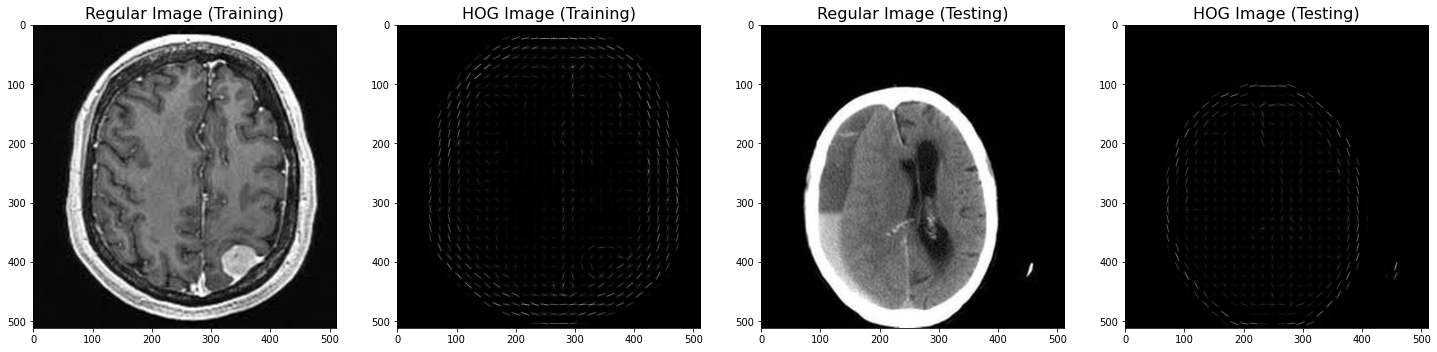

In [16]:
'''This cell generates four plots side-by-side to image[45] (the same one printed after loading the images) before
and after the HOG function to show what hog() does to the images.

This is done for image[45] from both the train and test sets to ensure the hog() works for each as it was done 
separately for the train data and test data.
'''
hog_vs_nohog, ax = plt.subplots(nrows=1, ncols=4, figsize=(25,25))
ax[0].imshow(np.array(xTrain[45]), cmap = 'gray') #A gray colormap is placed on the image
ax[0].set_title('Regular Image (Training)', fontsize = 16)
ax[1].imshow(np.array(images_hog_train[45]), cmap = 'gray') #A gray colormap is placed on the image
ax[1].set_title('HOG Image (Training)', fontsize = 16)
ax[2].imshow(np.array(xTest[45]), cmap = 'gray') #A gray colormap is placed on the image
ax[2].set_title('Regular Image (Testing)', fontsize = 16)
ax[3].imshow(np.array(images_hog_test[45]), cmap = 'gray') #A gray colormap is placed on the image
ax[3].set_title('HOG Image (Testing)', fontsize = 16)

The two cells below convert the list of features extracted using HOG into an array/matrix called the feature matrix.

As they were preprocessed separately, a feature matrix is generated for the training data in the first cell and for the testing data in the second cell. The shapes are printed to verify the array is now 2-dimensional after HOG and to ensure the correct number of data is present in each of the training and testing data according to the 75/25 split.

In [17]:
feature_matrix_training = np.array(features_hog_train) #Converting the list of features extracted from HOG into an array
print(feature_matrix_training.shape) #Printing the shape of the feature matrix to visually verify if it is acceptable

(2250, 72900)


In [18]:
feature_matrix_testing = np.array(features_hog_test)
print(feature_matrix_testing.shape)

(750, 72900)


In the cell below, `StandardScaler()` is used to standardise the features and scale to unit variance. This is done for the training feature matrix using `.fit_transform()` to calculate parameters and apply the transformation to the training feature matrix.

For the testing feature matrix, only `.transform()` is used to perform the transformation on the testing feature matrix but while using the same parameters calculated for the training feature matrix. This applies the same parameters calculated for the training set on our testing set.

In [19]:
std_scl = StandardScaler()
feature_matrix_training = std_scl.fit_transform(feature_matrix_training)
feature_matrix_testing = std_scl.transform(feature_matrix_testing)

print(feature_matrix_training.shape)
print(feature_matrix_testing.shape)

(2250, 72900)
(750, 72900)


After scaling, we set xTrain as the training feature matrix and xTest as the testing feature matrix. These are then fed into the PCA functions used later.

In [20]:
xTrain = feature_matrix_training
xTest = feature_matrix_testing

print(xTrain.shape)
print(xTest.shape)

(2250, 72900)
(750, 72900)


### PCA (Principle Component Analysis) for dimensionality reduction

In the cells below, we use PCA to reduce the features per image. PCA linearly transforms the data so that the most useful information is still contained in a smaller number of features. It removes the correlated features.

In the first cell, we generate a plot which shows how many features are needed to maintain a 95% explained variance. This means we are calculating the lowest possible number of features neeeded to retain 95% of the information. This reduces thef features significantly from 72,900 features to approx. 1400 features whilst retaining most of the useful information about the image.

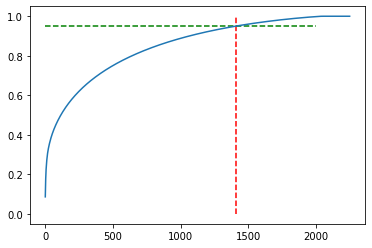

In [21]:
pca = PCA(random_state=0)
pca.fit(xTrain)
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.vlines(x=1409, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=2000, xmin=0, colors="g", linestyles="--")
plt.plot(explained_variance)

In the second cell, we shortcut the step used in the first cell. To retain 95% explained variance, we define our pca as `PCA(0.95)`. We also use `random_state = 0` for reproducibility. Similarly to our use of `StandardScaler()` above, we use `fit_transform()` on xTrain to find the parameters of the PCA and number of features as well as apply this transformation. 

However, then on xTest, we use `.transform()` to apply the transformation on the test set but by using the same parameters used for the training set to ensure the same number of features are retained for each. 

In [22]:
pca_final = PCA(0.95, random_state = 0)
pca_xTrain = pca_final.fit_transform(xTrain)
pca_xTest = pca_final.transform(xTest) #.transform() ensures same no. of features as calculated for xTrain

#Printing the shapes to verify both xTrain and xTest have the same number of features per image
print(pca_xTrain.shape)
print(pca_xTest.shape)

(2250, 1409)
(750, 1409)


## Training the models

In the following cells, we define the SVM model we are using by calling `SVC()` from `sklearn`. We then fit this to our training set using `xTrain` and `yTrain`.

Unlike in Logistic Regression for Task A where we initially only tested one model, we now initially test 3 models using 3 different kernel arguments (linear, poly and rbf). We also output the time taken for each model to train. 

The kernel used is a key part of the model and so it is useful to train three models, each with a different type of kernel from the 3 most common kernels: linear, polynomial and RBF (radial-basis function).

In [93]:
start_model1 = datetime.now()
model1_svmlinear = SVC(kernel='linear') 
model1_svmlinear.fit(pca_xTrain, yTrain) #Training the model by fitting it to our training data
end_model1 = datetime.now()
time_model1 = end_model1 - start_model1
print('The training time for Model 1 (SVM with Kernel = Linear) is: ', time_model1) 

The training time for Model 1 (SVM with Kernel = Linear) is:  0:00:00.676589


In [24]:
start_model2 = datetime.now()
model2_svmpoly = SVC(kernel = 'poly')
model2_svmpoly.fit(pca_xTrain, yTrain)
end_model2 = datetime.now()
time_model2 = end_model2 - start_model2
print('The training time for Model 2 (SVM with Kernel = Poly) is: ', time_model2)

The training time for Model 2 (SVM with Kernel = Poly) is:  0:00:02.173489


In [25]:
start_model3 = datetime.now()
model3_svmrbf = SVC(kernel = 'rbf')
model3_svmrbf.fit(pca_xTrain, yTrain)
end_model3 = datetime.now()
time_model3 = end_model3 - start_model3
print('The training time for Model 3 (SVM with Kernel = Rbf) is: ', time_model3)

The training time for Model 3 (SVM with Kernel = Rbf) is:  0:00:01.052985


## Predictions and Accuracy Metrics

In the following cells, we use `.predict()` to generate predictions using our test data and store it in `y_Pred`. This is then compared to `yTest` from the testing set to produce an accuracy score for the model as well as a classification report containing precision, recall and f1-scores. A classification report and confusion matrix is generated for each of the 3 trained models tested, whilst an ROC is only generated for the linear SVM as an example of ROC curves.

### Model 1 Prediction + Classification Report + Confusion Matrix

In [26]:
y_Pred_model1 = model1_svmlinear.predict(pca_xTest) #Making predictions on entire dataset using the model

In [27]:
print('Accuracy on test set: '+str(accuracy_score(yTest,y_Pred_model1)))
print(classification_report(yTest,y_Pred_model1)) #The classification report shows classification metrics such as f1-score, precison, recall and accuracy scores

Accuracy on test set: 0.9573333333333334
              precision    recall  f1-score   support

         0.0       0.93      0.80      0.86       123
         1.0       0.96      0.99      0.97       627

    accuracy                           0.96       750
   macro avg       0.95      0.89      0.92       750
weighted avg       0.96      0.96      0.96       750



In [28]:
acc_model1 = model1_svmlinear.score(pca_xTest, yTest) #Accuracy score

In [29]:
cm_model1 = confusion_matrix(yTest, y_Pred_model1) #Confusion matrix generated

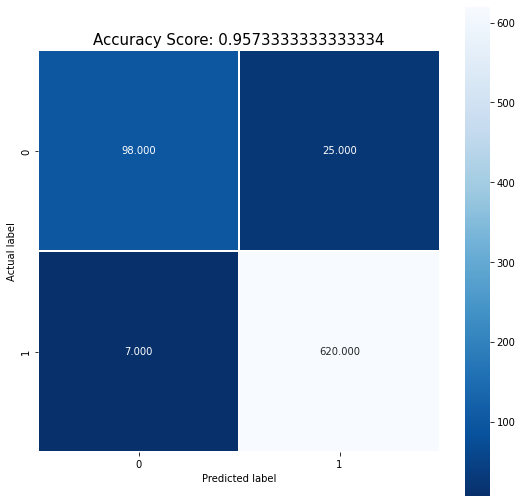

In [30]:
#The confusion matrix is plotted to visually show where the model performed best and worst in predicting the labels

plt.figure(figsize=(9,9))
sns.heatmap(cm_model1, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_model1)
plt.title(all_sample_title, size = 15);

### ROC Curves and AUC (Area under curve)

Note: DO NOT UNCOMMENT THESE CELLS UNLESS YOU SET `probability` to `probability = True` IN THE SVM MODEL

This calculates the receiver operating characteristic curve for the model. The ROC is close to the top left corner which shows an excellent model as the AUC (area under curve) is 0.99 which is very close to 1. The closer to the top left corner the better model as it shows high specificity and sensitivity at most points. This code to plot was taken from the `sklearn` library website as the default method of plotting ROCs. ROCs are considered useful as they also indicate specifity and sensitivity.

However, for SVM, this requires the argument `probability` to be set to `True` in the model `SVC()`. However, the default is `False` and  hence, we have commented this section out. When probability is True, training time is multiplied by at least 5 after observing over several test runs. Therefore, we only generated the ROC curve once and then commented out the cells. 

From the time we tried using ROC as an example, the ROC is close to the top left corner which shows an excellent model as the AUC is 0.99 which is very close to 1.

In [91]:
#ROC Curves - only use when probability = True in model

probabilities = model1_svmlinear.predict_proba(pca_xTest)
y_probability = probabilities[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(yTest, y_probability, pos_label=1)
roc_auc = auc(false_positive_rate, true_positive_rate)

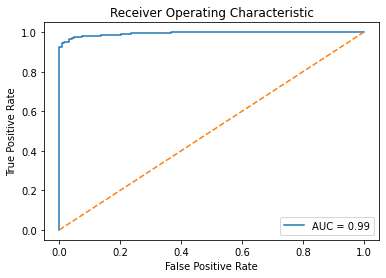

In [92]:
plt.title('Receiver Operating Characteristic')
#plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                     true_positive_rate,
                     label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

### Model 2 Prediction + Classification Report + Confusion Matrix

In [33]:
y_Pred_model2 = model2_svmpoly.predict(pca_xTest)

In [34]:
print('Accuracy on test set: '+str(accuracy_score(yTest,y_Pred_model2)))
print(classification_report(yTest,y_Pred_model2))

Accuracy on test set: 0.9346666666666666
              precision    recall  f1-score   support

         0.0       0.99      0.61      0.75       123
         1.0       0.93      1.00      0.96       627

    accuracy                           0.93       750
   macro avg       0.96      0.80      0.86       750
weighted avg       0.94      0.93      0.93       750



In [35]:
acc_model2 = model2_svmpoly.score(pca_xTest, yTest)

In [36]:
cm_model2 = confusion_matrix(yTest, y_Pred_model2)

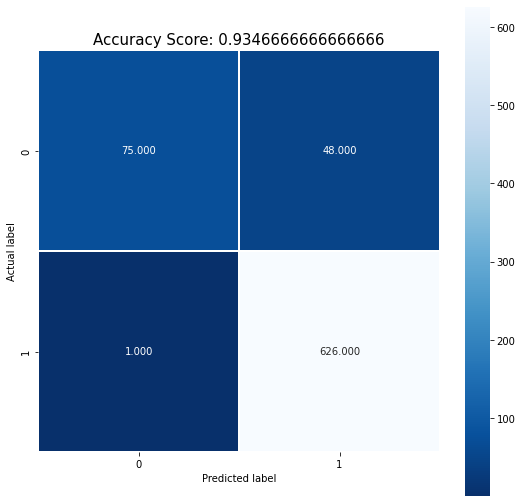

In [37]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_model2, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_model2)
plt.title(all_sample_title, size = 15);

### Model 3 Prediction + Classification Report + Confusion Matrix

In [38]:
y_Pred_model3 = model3_svmrbf.predict(pca_xTest)

In [39]:
print('Accuracy on test set: '+str(accuracy_score(yTest,y_Pred_model3)))
print(classification_report(yTest,y_Pred_model3))

Accuracy on test set: 0.9426666666666667
              precision    recall  f1-score   support

         0.0       0.93      0.71      0.80       123
         1.0       0.95      0.99      0.97       627

    accuracy                           0.94       750
   macro avg       0.94      0.85      0.88       750
weighted avg       0.94      0.94      0.94       750



In [40]:
acc_model3 = model3_svmrbf.score(pca_xTest, yTest)

In [41]:
cm_model3 = confusion_matrix(yTest, y_Pred_model3)

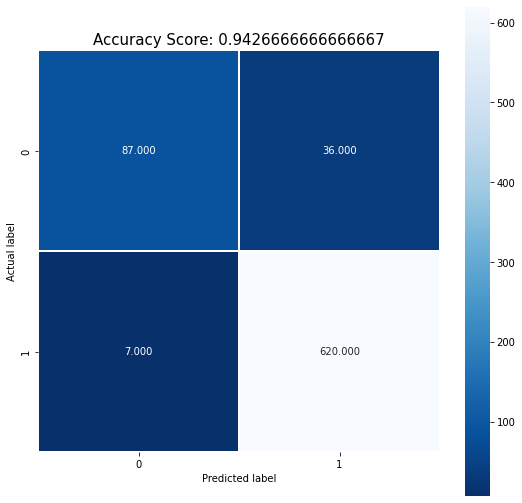

In [42]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_model3, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_model3)
plt.title(all_sample_title, size = 15);

## Learning Curves

In the cells below, a function `plot_learning_curve` is used to plot the learning curve for our logistic regression model. The learning curve is useful to show how the model is trained over time as well as any convergence. It shows how the model learns incrementally and can be used as a diagnostic tool.

This function and code was taken from the `sklearn` documentation on the sci-kit learn website on how to plot learning curves for ML models. In our case, we adapted the code to plot 3 sets of learning curves side by side, one for each of the 3 models trained.

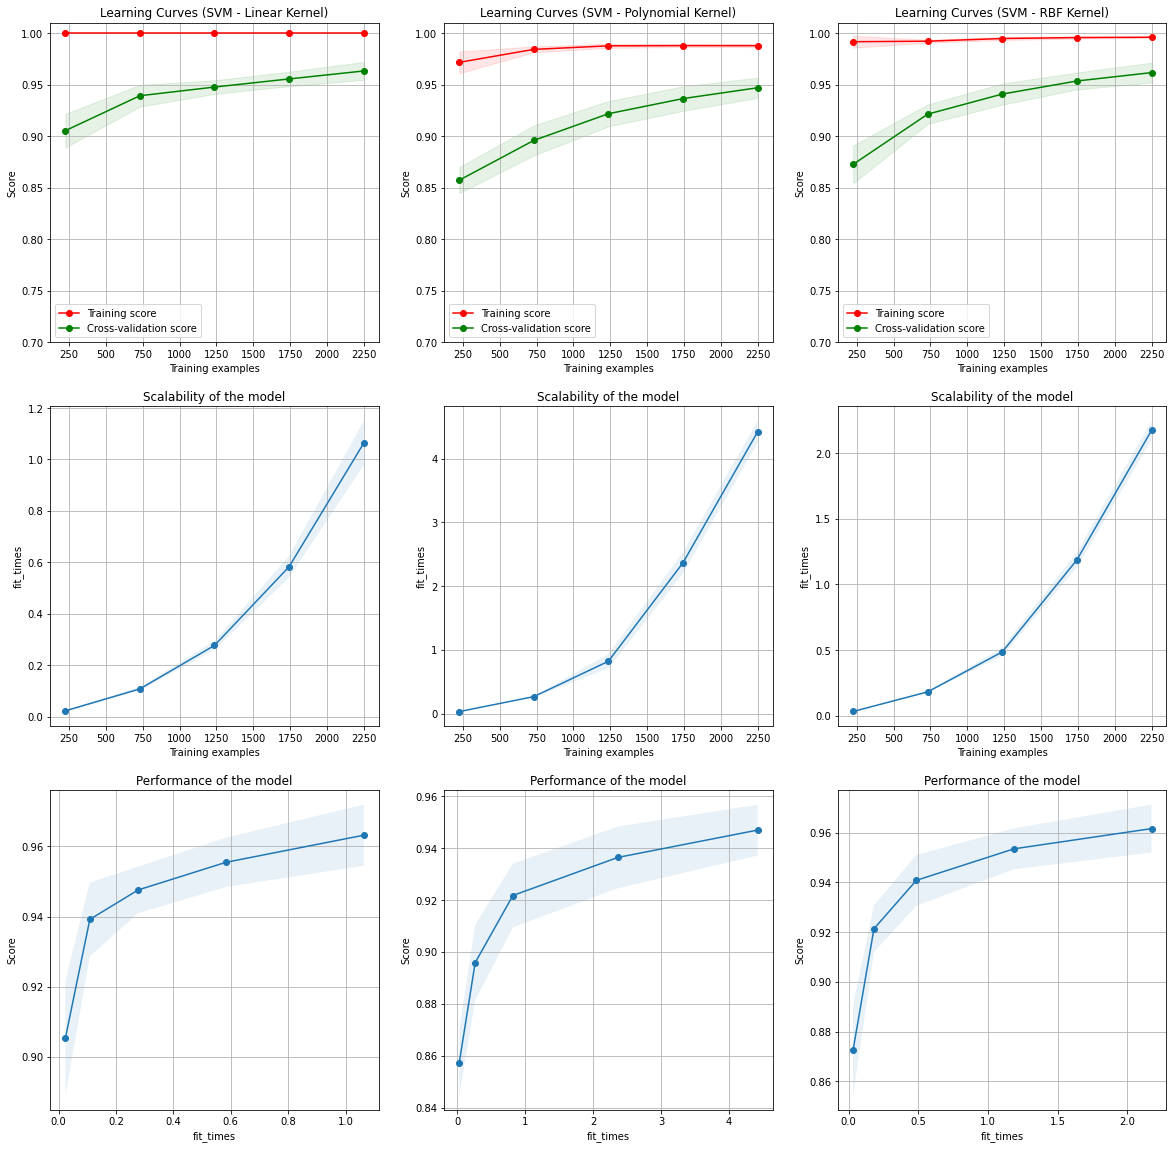

In [43]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, "o-")
    axes[2].fill_between(
        fit_times_mean,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 3, figsize=(20, 20))

xLearningCurve = np.concatenate([pca_xTrain, pca_xTest])
yLearningCurve = np.concatenate([yTrain, yTest])

title = r"Learning Curves (SVM - Linear Kernel)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
estimator = model1_svmlinear
plot_learning_curve(
    estimator, title, xLearningCurve, yLearningCurve, axes=axes[:, 0], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)


title = r"Learning Curves (SVM - Polynomial Kernel)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
estimator = model2_svmpoly
plot_learning_curve(
    estimator, title, xLearningCurve, yLearningCurve, axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)


title = r"Learning Curves (SVM - RBF Kernel)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
estimator = model3_svmrbf
plot_learning_curve(
    estimator, title, xLearningCurve, yLearningCurve, axes=axes[:, 2], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

plt.show()

### Hyperparameter Tuning using GridsearchCV

The hyperparameters of our model cannot be directly learned and so this gridsearch function using `GridSearchCV` tries a combination of all the parameters from the parameter grid defined below and the best combination with the highest accuracy score is determined.

This best combination of parameters is output along with the corresponding accuracy score to show our model after hyperparameter tuning. This model is then used to redo our predictions to see how much the predictions had improved by. 

In the case of binary SVM, we vary the C value, gamma, and the kernel chosen.

In [44]:
#Defining the parameter grid containing the different values we want to test for each parameter

param_grid = param_grid = {'C': [0.1, 1, 10, 100], 

              'gamma': [1, 0.1, 0.01],

              'kernel': ['linear', 'rbf', 'poly']} 
 
start_tune = datetime.now()
gridSVM = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
#Fitting the model for a gridsearch which goes the all the possible combinations of data
gridSVM.fit(pca_xTrain, yTrain)
end_tune = datetime.now()
time_tune = end_tune - start_tune
print('The time taken for Hyperparameter Tuning is: ', time_tune)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.956 total time=   0.5s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.971 total time=   0.5s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.973 total time=   0.5s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.960 total time=   0.5s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.967 total time=   0.5s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.851 total time=   2.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.853 total time=   2.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.853 total time=   2.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.853 total time=   2.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.853 total time=   2.1s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.947 total time=   1.7s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly

After completing the grid search for tuning, we output the best parameters as found by the grid search as well as the accuracy score produced by the model when these optimal parameters are used.

In [45]:
print('The best parameters are: ', gridSVM.best_params_)
print('Hence, the model we should use is: ', gridSVM.best_estimator_)
print('The accuracy /best score for this tuned model is: ', gridSVM.best_score_)

The best parameters are:  {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
Hence, the model we should use is:  SVC(C=0.1, gamma=1, kernel='linear')
The accuracy /best score for this tuned model is:  0.9653333333333334


In the cells below, we use identical code to those used to test the 3 models before. We use the tuned model along with `pca_xTest` to make predictions on the data set using the newly tuned hyperparameters. We also generate a classification report and confusion matrix to assess the performance of the newly tuned model.

In [46]:
tuned_predictions = gridSVM.predict(pca_xTest)
print('Accuracy on test set: '+str(accuracy_score(yTest,tuned_predictions)))
print(classification_report(yTest, tuned_predictions))

Accuracy on test set: 0.9573333333333334
              precision    recall  f1-score   support

         0.0       0.93      0.80      0.86       123
         1.0       0.96      0.99      0.97       627

    accuracy                           0.96       750
   macro avg       0.95      0.89      0.92       750
weighted avg       0.96      0.96      0.96       750



In [47]:
acc_tunedmodel = gridSVM.score(pca_xTest, yTest)

In [48]:
cm_tunedmodel = confusion_matrix(yTest, tuned_predictions)

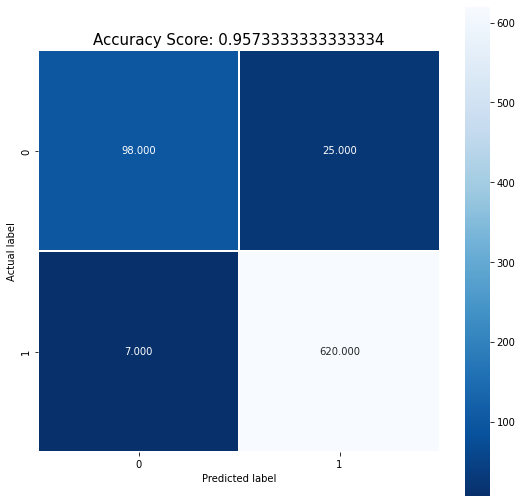

In [49]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_tunedmodel, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_tunedmodel)
plt.title(all_sample_title, size = 15);

### Hyperparameter tuning second round

A second round of tuning using a second grid search and a parameter grid with more specific values in a smaller interval is used. The process used is identical of carrying out the gridsearch, printing out the best parameters and score, as well as making a prediction on the dataset to generate a new classification report and confusion matrix.

In the first round of tuning, the accuracy and classification report given are almost identical to Model 1, but the C value is different. So it was worth running another tuning cycle with more specific C values in a smaller range to see if that parameter could be optimised any further.

The output of the grid search remains the same by telling us to use C = 0.1, meaning that the accuracy also remains the same, however, it was worth checking to see if the model could have been enhanced any further.

In [50]:
#Defining the parameter grid containing the different values we want to test for each parameter

param_grid2 = param_grid2 = {'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 5], 

              'gamma': [1, 0.1],

              'kernel': ['linear', 'rbf', 'poly']} 
 
start_tune2 = datetime.now()
gridSVM2 = GridSearchCV(SVC(), param_grid2, refit = True, verbose = 3)
 
#Fitting the model for a gridsearch which goes the all the possible combinations of data
gridSVM2.fit(pca_xTrain, yTrain)
end_tune2 = datetime.now()
time_tune2 = end_tune2 - start_tune2
print('The time taken for Hyperparameter Tuning is: ', time_tune2)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.956 total time=   0.5s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.971 total time=   0.5s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.973 total time=   0.5s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.960 total time=   0.5s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.967 total time=   0.5s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.851 total time=   2.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.853 total time=   2.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.853 total time=   2.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.853 total time=   2.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.853 total time=   2.0s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.947 total time=   1.7s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly

In [51]:
print('The best parameters are: ', gridSVM2.best_params_)
print('Hence, the model we should use is: ', gridSVM2.best_estimator_)
print('The accuracy /best score for this tuned model is: ', gridSVM2.best_score_)

The best parameters are:  {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
Hence, the model we should use is:  SVC(C=0.1, gamma=1, kernel='linear')
The accuracy /best score for this tuned model is:  0.9653333333333334


In [52]:
tuned_predictions2 = gridSVM2.predict(pca_xTest)
print('Accuracy on test set: '+str(accuracy_score(yTest,tuned_predictions)))
print(classification_report(yTest, tuned_predictions))

Accuracy on test set: 0.9573333333333334
              precision    recall  f1-score   support

         0.0       0.93      0.80      0.86       123
         1.0       0.96      0.99      0.97       627

    accuracy                           0.96       750
   macro avg       0.95      0.89      0.92       750
weighted avg       0.96      0.96      0.96       750



In [53]:
acc_tunedmodel2 = gridSVM2.score(pca_xTest, yTest)

In [54]:
cm_tunedmodel2 = confusion_matrix(yTest, tuned_predictions2)

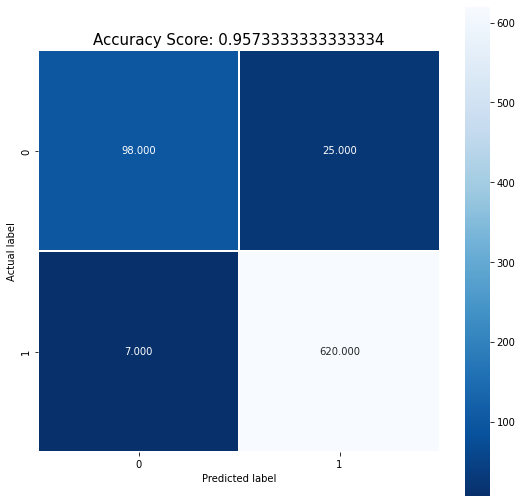

In [55]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_tunedmodel2, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_tunedmodel2)
plt.title(all_sample_title, size = 15);

## Testing and reporting accuracy scores using new separate 'test' data set

In the following cells, we use similar methods to the ones used above to load the images from the new test set uploaded recently. This new separate test data set was uploaded a week prior to the deadline. We then carry out identical preprocessing techniques to those we did above and those were HOG followed by PCA. 

### Loading the labels and images from the test set

The cells below load the labels and then the images from the test set. They are loaded indentically to how they were loaded from the larger 'dataset' test set:

* All the labels not reading 'no_tumor' are converted to 'tumor' to make the problem binary.
* An extra column is added to the dataframe for numeric representation of the labels using 1 or 0.
* The images are converted to grayscale using `rgb2gray()`.

In [56]:
#Two different paths given: top line is for using Google Drive with Colab and bottom is for in all other situations. Comment and uncomment accordingly.

#new_tumour_labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test/label.csv')
new_tumour_labels = pd.read_csv('./test/label.csv')

print(new_tumour_labels.shape) #Outputs array with the shape of the dataframe to ensure all images, filenames and labels loaded

(200, 2)


In [57]:
new_tumour_labels

,file_name,label
0,IMAGE_0000.jpg,meningioma_tumor
1,IMAGE_0001.jpg,meningioma_tumor
2,IMAGE_0002.jpg,glioma_tumor
3,IMAGE_0003.jpg,pituitary_tumor
4,IMAGE_0004.jpg,glioma_tumor
...,...,...
195,IMAGE_0195.jpg,pituitary_tumor
196,IMAGE_0196.jpg,no_tumor
197,IMAGE_0197.jpg,meningioma_tumor
198,IMAGE_0198.jpg,no_tumor


In [58]:
#change anything in the label column that is not equal to "no_tumor" to "tumor" rather than the type of tumor
new_tumour_labels.loc[new_tumour_labels['label']!= 'no_tumor', 'label'] = 'tumor' 

In [59]:
new_tumour_labels

,file_name,label
0,IMAGE_0000.jpg,tumor
1,IMAGE_0001.jpg,tumor
2,IMAGE_0002.jpg,tumor
3,IMAGE_0003.jpg,tumor
4,IMAGE_0004.jpg,tumor
...,...,...
195,IMAGE_0195.jpg,tumor
196,IMAGE_0196.jpg,no_tumor
197,IMAGE_0197.jpg,tumor
198,IMAGE_0198.jpg,no_tumor


In [60]:
for CLASS in classes:
    new_tumour_labels.loc[new_tumour_labels['label'] == CLASS, 'numeric label'] = classes.index(CLASS)

In [61]:
new_tumour_labels

,file_name,label,numeric label
0,IMAGE_0000.jpg,tumor,1.0
1,IMAGE_0001.jpg,tumor,1.0
2,IMAGE_0002.jpg,tumor,1.0
3,IMAGE_0003.jpg,tumor,1.0
4,IMAGE_0004.jpg,tumor,1.0
...,...,...,...
195,IMAGE_0195.jpg,tumor,1.0
196,IMAGE_0196.jpg,no_tumor,0.0
197,IMAGE_0197.jpg,tumor,1.0
198,IMAGE_0198.jpg,no_tumor,0.0


### Test set images loading

The time elapsed to load the images was:  0:00:03.705167
(200, 512, 512)


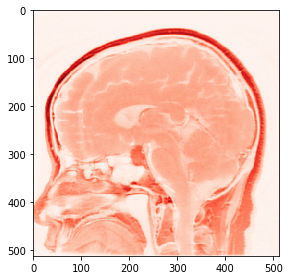

In [62]:
#Uncomment to verify contents of the directory loaded

""" directoryNEW contains the path of the image folder of the new test set on the computer for running on Jupyter notebook when all files are in the same directory  
    drive_directoryNEW contains the path of the image folder of the new test set on Google Drive for when Colab was being used for higher computational power.

    NOTE: As the order of the images was reshuffled when being uploaded to Google Drive due to internet speeds, we must use sorted() at the
    beginning of the for-loop when using dirpath otherwise the images will not be loaded in the order matching their corresponding labels. 
    Explicity this means when using Colab the for loop should read "for file in sorted(listdir(drive_directory))" instead of
    "for file in listdir(directory)".
    
    Change the name of the path in the for loop accordingly."""

#Defines the directory name and stores it in dirname
drive_directoryNEW = '/content/drive/MyDrive/Colab Notebooks/test/image'
directoryNEW = './test/image'
#print(listdir(dirname))

#Code used to test timing

start = datetime.now() #Stores the time at which loading starts

validation_images = [] #An empty list is created to store the images from the new test set uploaded most recently 

"""The for loop below uses listdir to iterate through names of all the files in the directory and uses to
populate the list images. The image is converted into grayscale using rgb2gray as this grayscale images only
have one channel which will increase efficiency of the code as we and decrease complexity whilst still yielding 
similar results. Testing carried out by me showed that we should stick to grayscale.

The user can optionally comment out lines 34-36 and uncomment lines 38 and 39 to leave the image in RGB rather
than convert it to grayscale"""

for file in sorted(listdir(directoryNEW)):
    img = io.imread(directoryNEW + '/' + file)
    gray_img = rgb2gray(img)
    gray_img = np.array(gray_img)
    validation_images.append(gray_img)
    
    #img = np.array(img)
    #images.append(img) 
        
#Marking the end of the code loading the images 
end = datetime.now()
elapsed = end - start #Calculating time elapsed while comparing different packages used to load images
print('The time elapsed to load the images was: ', + elapsed) 

"""Below we chose a random image from the dataset (image[45]) to show below so the user can visually verify
the type of image. We apply a red colormap in the imshow function so that if the image is shown with red tones
the user knows it was converted to grayscale and if it shows as a regular black and white MRI then it was not."""

io.imshow(np.array(validation_images[45]), cmap='Reds') #red colormap only appears if grayscale image
print(np.array(validation_images).shape) #Converting list images to a numpy array before outputting shape to verify 

The data is stored in xVal (images) and yVal (labels) and there is no need for splitting the data. This is because the models are already trained we are using the entirety of the 'test' zip folder for testing and none of it is used for training. Hence, we immediately test the new data after preprocessing.

We name the new test data with the keyword "Val" to indicate the new data is being used to validate the previously trained model works on unseen data.

In [63]:
xVal = np.array(validation_images)
yVal = new_tumour_labels['numeric label']

print(xVal.shape) #We print the shape of x_val to ensure the features in the testing set are of the quantity expected


(200, 512, 512)


## Preprocessing: HOG and PCA

The process carried out is identical to that used for the original 'dataset' but none of the data is used for training.

A histogram of oriented gradients feature vector and image is generated for each image in the new unseen separate 'test' dataset. The feature vectors are appended to a list and then converted using a numpy array to create a feature matrix.

Using `.transform()` instead of `.fit_transform()`, we apply `StandardScaler()` and `PCA()` to the new test set. This ensure the same parameters calculated for the original training data are used when performing the transformation for the new test data.

In [64]:
validation_features_hog = []
validation_images_hog = []

for index in range(len(xVal)):
    hog_feature_val, hog_image_val = hog(xVal[index], visualize = True, block_norm = 'L2-Hys', pixels_per_cell=(16,16))
    validation_features_hog.append(hog_feature_val)
    validation_images_hog.append(hog_image_val)


In [65]:
print(np.array(validation_features_hog).shape)
print(np.array(validation_images_hog).shape)

(200, 72900)
(200, 512, 512)


In [66]:
validation_feature_matrix = np.array(validation_features_hog)
print(validation_feature_matrix.shape)

(200, 72900)


In [67]:
validation_feature_matrix = std_scl.transform(validation_feature_matrix)
print(validation_feature_matrix.shape)

(200, 72900)


In [68]:
pca_xVal = pca_final.transform(validation_feature_matrix)

In [69]:
print(pca_xVal.shape) #We print shape after PCA to ensure it has the same no. of features as xTrain and xTest after PCA

(200, 1409)


## Testing Model 1

Testing Model 1 (Linear SVM) by making predictions on `pca_xVal` and then printing out an accuracy score, classification report and confusion matrix.

In [70]:
y_val_Pred_model1 = model1_svmlinear.predict(pca_xVal)

In [71]:
print('Accuracy on new validation set: '+str(accuracy_score(yVal,y_val_Pred_model1)))
print(classification_report(yVal,y_val_Pred_model1)) #A text report displaying the main classification metrics

Accuracy on new validation set: 0.965
              precision    recall  f1-score   support

         0.0       0.97      0.84      0.90        37
         1.0       0.96      0.99      0.98       163

    accuracy                           0.96       200
   macro avg       0.97      0.92      0.94       200
weighted avg       0.97      0.96      0.96       200



In [72]:
acc_new_model1 = model1_svmlinear.score(pca_xVal, yVal)

In [73]:
new_cm_model1 = confusion_matrix(yVal, y_val_Pred_model1)

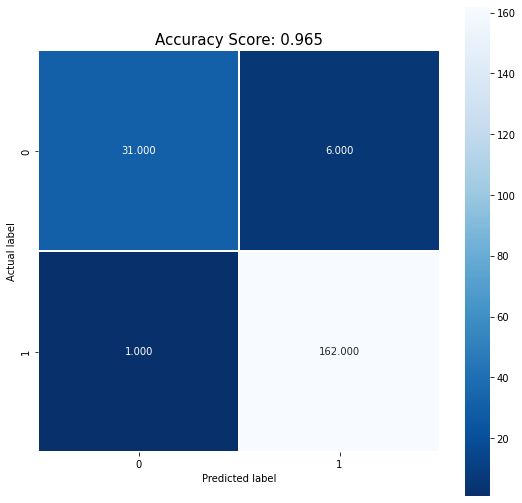

In [74]:
plt.figure(figsize=(9,9))
sns.heatmap(new_cm_model1, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_new_model1)
plt.title(all_sample_title, size = 15);

## Testing Model 2

Testing Model 2 (Polynomial SVM) by making predictions on `pca_xVal` and then printing out an accuracy score, classification report and confusion matrix.

In [75]:
y_val_Pred_model2 = model2_svmpoly.predict(pca_xVal)

In [76]:
print('Accuracy on new validation set: '+str(accuracy_score(yVal,y_val_Pred_model2)))
print(classification_report(yVal,y_val_Pred_model2)) #A text report displaying the main classification metrics

Accuracy on new validation set: 0.91
              precision    recall  f1-score   support

         0.0       0.95      0.54      0.69        37
         1.0       0.91      0.99      0.95       163

    accuracy                           0.91       200
   macro avg       0.93      0.77      0.82       200
weighted avg       0.91      0.91      0.90       200



In [77]:
acc_new_model2 = model2_svmpoly.score(pca_xVal, yVal)

In [78]:
new_cm_model2 = confusion_matrix(yVal, y_val_Pred_model2)

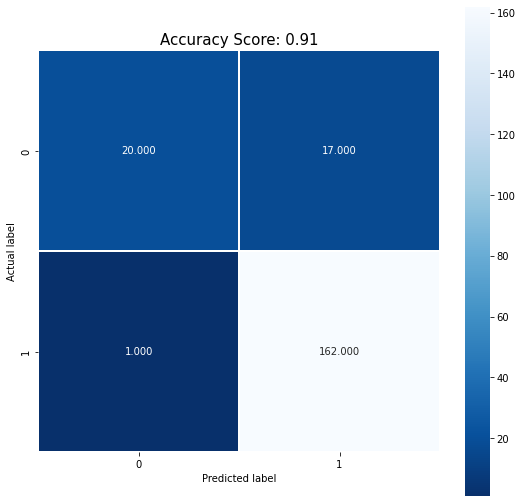

In [79]:
plt.figure(figsize=(9,9))
sns.heatmap(new_cm_model2, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_new_model2)
plt.title(all_sample_title, size = 15);

## Testing Model 3

Testing Model 3 (RBF Kernel SVM) by making predictions on `pca_xVal` and then printing out an accuracy score, classification report and confusion matrix.

In [80]:
y_val_Pred_model3 = model3_svmrbf.predict(pca_xVal)

In [81]:
print('Accuracy on new validation set: '+str(accuracy_score(yVal,y_val_Pred_model3)))
print(classification_report(yVal,y_val_Pred_model3)) #A text report displaying the main classification metrics

Accuracy on new validation set: 0.965
              precision    recall  f1-score   support

         0.0       0.97      0.84      0.90        37
         1.0       0.96      0.99      0.98       163

    accuracy                           0.96       200
   macro avg       0.97      0.92      0.94       200
weighted avg       0.97      0.96      0.96       200



In [82]:
acc_new_model3 = model3_svmrbf.score(pca_xVal, yVal)

In [83]:
new_cm_model3 = confusion_matrix(yVal, y_val_Pred_model3)

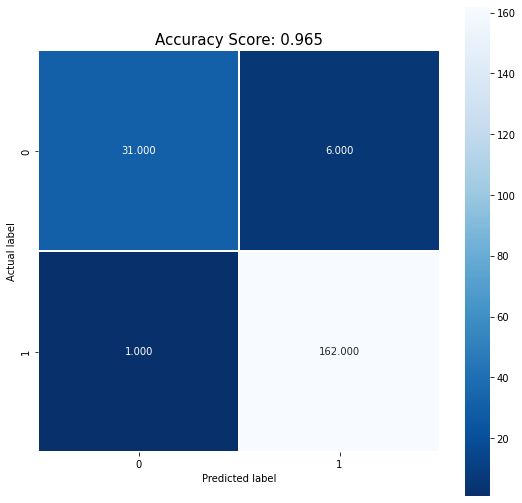

In [84]:
plt.figure(figsize=(9,9))
sns.heatmap(new_cm_model3, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_new_model3)
plt.title(all_sample_title, size = 15);

## Testing the model with hypertuned parameters on new 'test' set

Using the new unseen test set on the tuned model to generate an accuracy score, classification report and confusion matrix.

In [85]:
tuned_predictions_newset = gridSVM.predict(pca_xVal)
print('Accuracy on test set: '+str(accuracy_score(yVal,tuned_predictions_newset)))
print(classification_report(yVal,tuned_predictions_newset))

Accuracy on test set: 0.965
              precision    recall  f1-score   support

         0.0       0.97      0.84      0.90        37
         1.0       0.96      0.99      0.98       163

    accuracy                           0.96       200
   macro avg       0.97      0.92      0.94       200
weighted avg       0.97      0.96      0.96       200



In [86]:
acc_tunedmodel_newset = gridSVM.score(pca_xVal, yVal)

In [87]:
cm_tunedmodel_newset = confusion_matrix(yVal, tuned_predictions_newset)

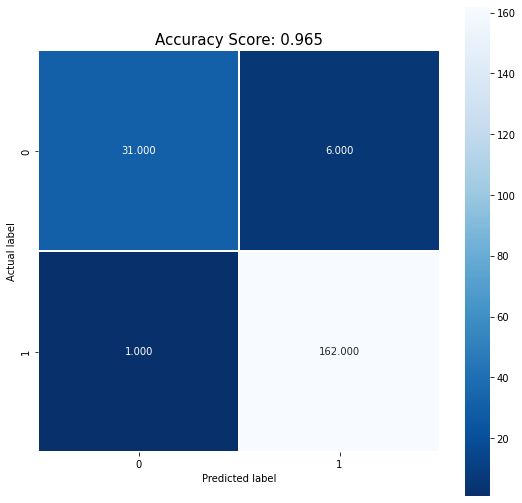

In [88]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_tunedmodel_newset, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_tunedmodel_newset)
plt.title(all_sample_title, size = 15);

In [89]:
taskA_end = datetime.now()
taskA_time = taskA_end - taskA_start
print('The time taken to run this script for Task A using SVM was: ', taskA_time)

The time taken to run this script for Task A using SVM was:  0:26:13.111352
